# Importing modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from statsmodels.tsa.stattools import adfuller

/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv


# Dataset

In [2]:
train = pd.read_csv('/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv')

Converting the datetime feature to the required form using the pandas to_datetime feature

In [3]:
def preprocessing(train):
    train['Date'] = pd.to_datetime(train['Date'])
    return train

In [4]:
train = preprocessing(train)
train.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [5]:
train.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1825 non-null   datetime64[ns]
 1   High       1825 non-null   float64       
 2   Low        1825 non-null   float64       
 3   Open       1825 non-null   float64       
 4   Close      1825 non-null   float64       
 5   Volume     1825 non-null   float64       
 6   Adj Close  1825 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 99.9 KB


# EDA

The correlation plot is checked in order to understand how each feature is relaed to the other ones

Here I have used the *sns.heatmap* function and the inbuilt function *corr()* to get the correlation

<AxesSubplot:>

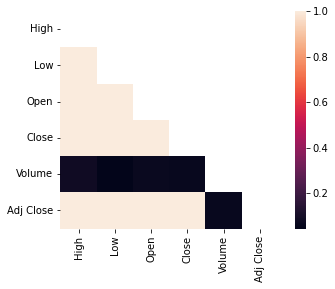

In [11]:
import seaborn as sns
corr_matrix = train.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask=mask, square=True)

Checking the timeseries variable using a time plot

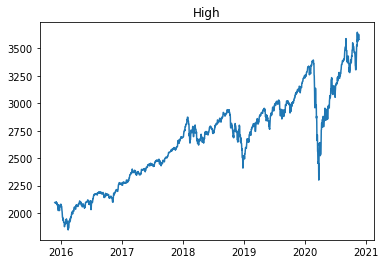

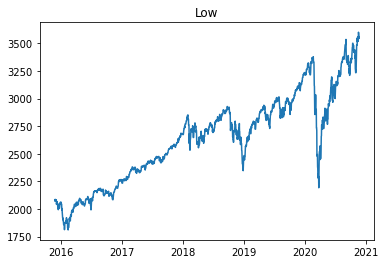

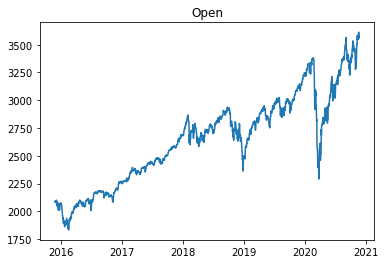

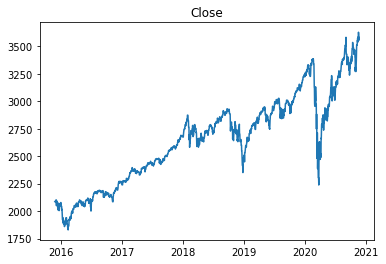

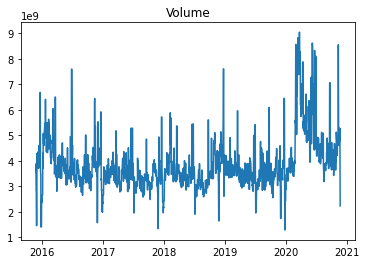

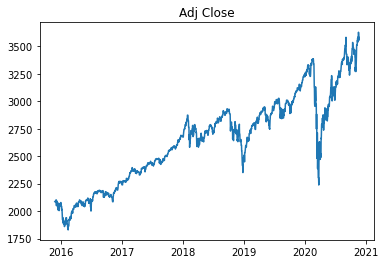

In [8]:
for col in train.columns[1:]:
    plt.plot(train['Date'], train[col])
    plt.title(col)
    plt.show()

Checking the rolling mean ver a period of 1 year to see stationarity visually

In [ ]:
z = train.rolling(365).mean()

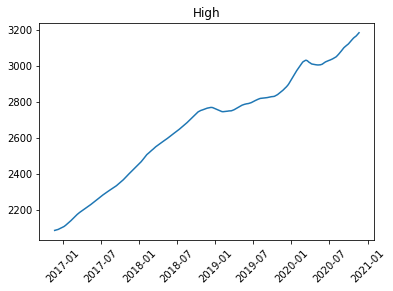

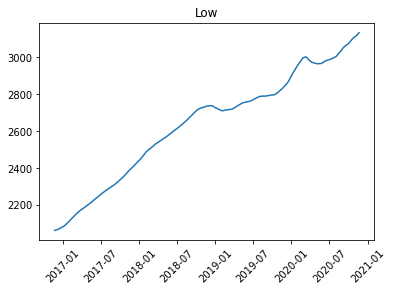

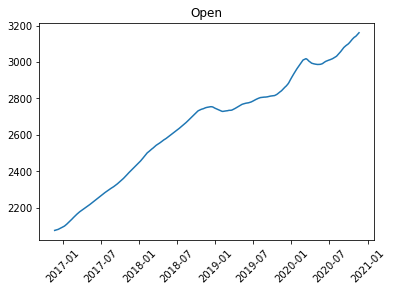

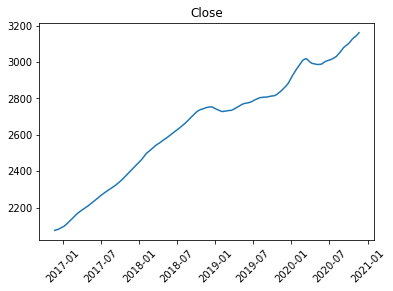

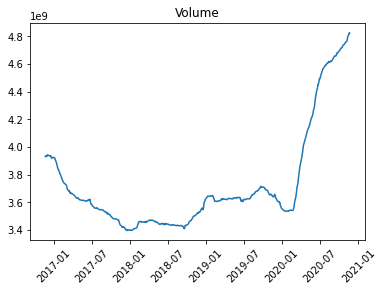

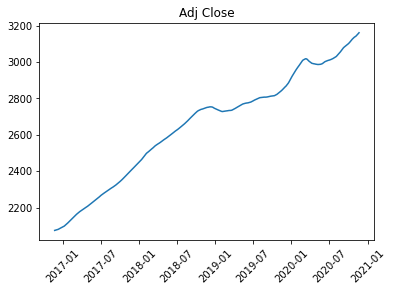

In [9]:
for col in z.columns:
    plt.plot(train['Date'], z[col], label=col)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

From the above plots we can clearly see that all the variables except the volume variable is unstationary

Unstationary dataset variables can pose a issue while modelling and hence just to confirm my visual intuition let's add a few statistaical parameters namely the adfuller test.

References : 

Adfuller test [official documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

[Non-stationary dataset explanation](https://www.investopedia.com/articles/trading/07/stationary.asp) 

In [12]:
for col in train.columns:
    if col == 'Date' : 
        continue
    else:
#         print("-"*7 + col + "-"*7)
        adfuller_result = adfuller(train[col].values, autolag='AIC')
#         print(f'ADF Statistic: {adfuller_result[0]}')
#         print(f'p-value: {adfuller_result[1]}')
#         for key, value in adfuller_result[4].items():
#             print('Critial Values:')
#             print(f'   {key}, {value}')
        if adfuller_result[1] < 0.7:
            print(f'{col} is stationary at {adfuller_result[1]}')
        else:
            print(f'{col} is unstationary at {adfuller_result[1]}')

High is unstationary at 0.8431957237480057
Low is unstationary at 0.7319468442688248
Open is unstationary at 0.8027857617750189
Close is unstationary at 0.7975646340657458
Volume is stationary at 7.629354879689879e-05
Adj Close is unstationary at 0.7975646340657458


Stationarizing the data. 

Here I have used a method from [here](https://towardsdatascience.com/how-to-remove-non-stationarity-in-time-series-forecasting-563c05c4bfc7).

5.3658919419228965e-14


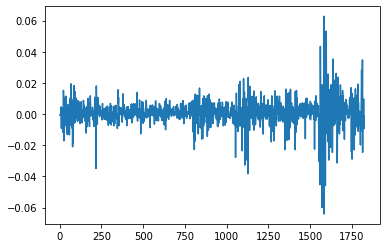

2.476883124402237e-19


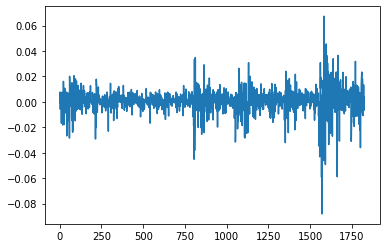

1.6559706061890547e-18


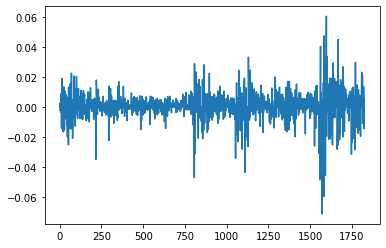

1.785642523813622e-13


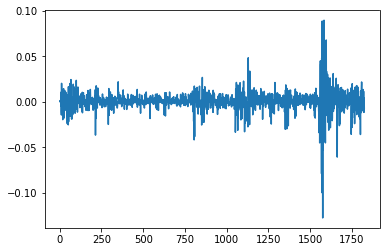

4.2763654529039e-24


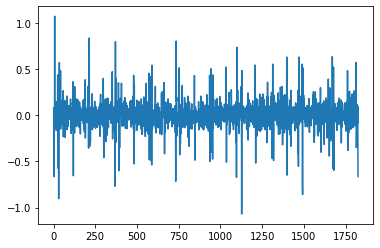

1.785642523813622e-13


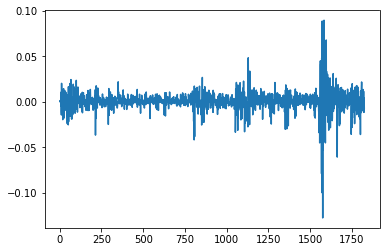

In [13]:
for col in train.columns[1:]:
    z = pd.Series(np.log(train[col])).diff().dropna()
    plt.plot(z)
    adfuller_result = adfuller(z.values, autolag='AIC')
    print(adfuller_result[1])
    plt.show()

# Testing

The code from here on is still under testing and i will post the latest notebook as soon as i get results from the modelling part. 

I would love to hear if there is anything you think i could improve on and your vies on the above procedure. 

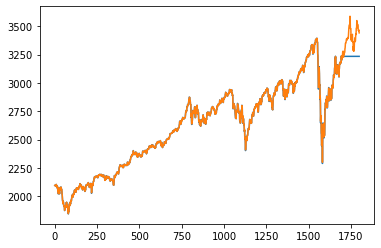

In [14]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['High'].iloc[:1700].values, order=(1, 1, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(1, 1800, typ='levels')
# print(yhat)

plt.plot(yhat, label='Pred')
plt.plot(train['High'].iloc[:1800].values, label='Truth values')
plt.show()
# def plotter_funct(z, yhat):
#     plt.plot(yhat, label='Predicted')
#     plt.plot(z, color='red', label='Truth values')
#     plt.legend()
#     plt.show()

# for col in train.columns[1:]:
    
#     model = AutoReg(train[col].iloc[:1300].values, lags=1)
#     model_fit = model.fit()

#     yhat = model_fit.predict(0,1800)
    
#     plotter_funct(train[col], yhat)
    
#     z = pd.Series(np.log(train[col])).diff().dropna()
#     model = AutoReg(z, lags=1)
#     model_fit = model.fit()
    
#     yhat = model_fit.predict(0,1800)
    
#     plotter_funct(z[:1700], yhat)

In [15]:
train['Close_lag_1'] = train['Close'].shift(1)
train['Volume_lag_1'] = train['Volume'].shift(1)
train['Open_lag_1'] = train['Open'].shift(1)
train['High_lag_1'] = train['High'].shift(1)
train['High_lag_2'] = train['High'].shift(2)
train['High_lag_3'] = train['High'].shift(3)
train.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Close_lag_1,Volume_lag_1,Open_lag_1,High_lag_1,High_lag_2,High_lag_3
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893,2086.590088,3.587980e+09,2089.409912,2095.610107,NaN,NaN
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117,2089.139893,3.884930e+09,2084.419922,2094.120117,2095.610107,NaN
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117,2088.870117,2.852940e+09,2089.300049,2093.000000,2094.120117,2095.610107
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107,2088.870117,2.852940e+09,2089.300049,2093.000000,2093.000000,2094.120117


In [16]:
train = train.drop(['Low', 'Open', 'Close', 'Volume', 'Adj Close'],axis=1)
# train.head()
train = train.fillna(0)
train.head()

,Date,High,Close_lag_1,Volume_lag_1,Open_lag_1,High_lag_1,High_lag_2,High_lag_3
0,2015-11-23,2095.610107,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1,2015-11-24,2094.120117,2086.590088,3.587980e+09,2089.409912,2095.610107,0.000000,0.000000
2,2015-11-25,2093.000000,2089.139893,3.884930e+09,2084.419922,2094.120117,2095.610107,0.000000
3,2015-11-26,2093.000000,2088.870117,2.852940e+09,2089.300049,2093.000000,2094.120117,2095.610107
4,2015-11-27,2093.290039,2088.870117,2.852940e+09,2089.300049,2093.000000,2093.000000,2094.120117


In [17]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(train, test_size=0.25, shuffle=False)

In [18]:
X,y = train_df[train.columns[2:]], train_df['High']
X_test,y_test = test_df[train.columns[2:]], test_df['High']

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
model = XGBRegressor()
model.fit(X, y)
y_hat = model.predict(X_test)
plt.plot(y_hat)
plt.plot(y_test.values)

error = mean_absolute_error(y_test.values, y_hat)
# evaluate = model.score(y_test.values, y_hat)
print(f'Error is {error}')#, evaluate)

In [ ]:
from scipy.signal import periodogram
freqencies, spectrum = periodogram(
    train['Open'],
    fs=365,
    detrend='linear',
    window="boxcar",
    scaling='spectrum',
)
_, ax = plt.subplots()
ax.step(freqencies, spectrum, color="purple")
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(
    [
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ],
    rotation=30,
)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_ylabel("Variance")
ax.set_title("Periodogram")

In [ ]:
train = train.set_index('Date')

In [ ]:
# from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

# dp = DeterministicProcess(
#     index=train.index,
#     constant=True,               # dummy feature for bias (y-intercept)
#     order=1,                     # trend (order 1 means linear)
#     seasonal=True,               # weekly seasonality (indicators)
#     additional_terms=[fourier],  # annual seasonality (fourier)
#     drop=True,                   # drop terms to avoid collinearity
# )

# X = dp.in_sample()

In [ ]:
# dp

In [ ]:
# from sklearn.linear_model import LinearRegression
# y = train["Low"]

# model = LinearRegression(fit_intercept=False)
# _ = model.fit(X, y)

# y_pred = pd.Series(model.predict(X), index=y.index)
# X_fore = dp.out_of_sample(steps=90)
# y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

# ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
# ax = y_pred.plot(ax=ax, label="Seasonal")
# ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
# _ = ax.legend()

In [ ]:
z = train.rolling(365).mean()